In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

import math
from sklearn.decomposition import PCA

In [32]:
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def includedInCone(point, vertex, threshhold_quadratic_function):
    if point[1] >= vertex[1]:
        y_distance = point[1] - vertex[1]
        
        x1 = vertex[0] - threshhold_quadratic_function * math.sqrt(y_distance)  
        x2 = vertex[0] + threshhold_quadratic_function * math.sqrt(y_distance)  
        
        return x1 < point[0] < x2
    return False

def brighten_image(image, factor):
    if factor < 0 or factor > 255:
        raise ValueError("Factor must be between 0 and 255.")
    brightened_image = image.astype(np.int16) + factor
    return np.clip(brightened_image, 0, 255).astype(np.uint8)

def enhance_contrast(image, factor):
    if factor < 0:
        raise ValueError("Factor must be positive.")
    contrast_image = image.astype(np.int16)
    contrast_image = 128 + factor * (contrast_image - 128)
    return np.clip(contrast_image, 0, 255).astype(np.uint8)

def prepareMask(emptyFrame, dartFrame):
    brightness_factor = 100
    empty_dartboard_bright = brighten_image(emptyFrame, brightness_factor)
    dartboard_with_darts_bright = brighten_image(dartFrame, brightness_factor)

    contrast_factor = 1.2
    empty_dartboard_contrast = enhance_contrast(empty_dartboard_bright, contrast_factor)
    dartboard_with_darts_contrast = enhance_contrast(dartboard_with_darts_bright, contrast_factor)
    
    empty_gray = cv2.cvtColor(empty_dartboard_contrast, cv2.COLOR_BGR2GRAY)
    darts_gray = cv2.cvtColor(dartboard_with_darts_contrast, cv2.COLOR_BGR2GRAY)
    
    difference = cv2.absdiff(empty_gray, darts_gray) 
    
    _, mask = cv2.threshold(difference, 40, 255, cv2.THRESH_BINARY)
    cv2.imwrite("premask.jpg",difference)
    
    kernel = np.ones((4, 4), np.uint8) 
    mask_eroded = cv2.erode(mask, kernel, iterations=1)
    return mask_eroded

def findPointsInMask(mask, min_area_threshold):
    #Find Centerpoints in Contours of Mask
    contours_in_mask, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    centroids = []

    for contour_mask in contours_in_mask:
        area = cv2.contourArea(contour_mask)
        
        if area > min_area_threshold:
            #Append Highgest Point
            topmost_point = min(contour_mask, key=lambda point: point[0][1])  
            cx, cy = int(topmost_point[0][0]), int(topmost_point[0][1])
            centroids.append((cx, cy))
            #Append Centerpoints
            M = cv2.moments(contour_mask)
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                centroids.append((cx, cy))
    return centroids

def findClosestPoint(current_point, centroids):
    nearest_point = None
    min_distance = float('inf')
    for centroid in centroids:
        distance = euclidean_distance(centroid, current_point)
        
        if distance < min_distance:
            min_distance = distance
            nearest_point = centroid
    return nearest_point

def findClosestPointBasedOnLine(slope, intercept, points, init_y):
    nearest_point = None
    min_distance_to_line = float('inf')
    
    for point in points:
        x0, y0 = point 

        y_position_on_dart = abs(y0 - init_y)

        if y_position_on_dart < 200:
            max_distance_threshhold = 25
        elif y_position_on_dart < 300:
            max_distance_threshhold = 30
        elif y_position_on_dart < 400:
            max_distance_threshhold = 35
        else:
            max_distance_threshhold = 85

        distance_to_line = abs(slope * x0 - y0 + intercept) / np.sqrt(slope**2 + 1)

        if distance_to_line < min_distance_to_line and distance_to_line < max_distance_threshhold:
            min_distance_to_line = distance_to_line
            nearest_point = point

    return nearest_point

def calculateLine(points):
    x = np.array([point[0] for point in points])
    y = np.array([point[1] for point in points])

    #PCA Hauptkomponenten Analyse
    pca = PCA(n_components=1)
    pca.fit(points)

    slope = pca.components_[0][1] / pca.components_[0][0]
    intercept = np.mean(y) - slope * np.mean(x)

    return slope, intercept

def drawLine(slope, line_mask, start_point):
    line_length = 600

    x_offset = line_length / np.sqrt(1 + slope**2)
    y_offset = slope * x_offset

    end_point = (int(start_point[0] + (x_offset if slope >= 0 else -x_offset)),
                int(start_point[1] + (y_offset if slope >= 0 else -y_offset)))
    
    cv2.line(line_mask, start_point, end_point, (255, 255, 255), 2)

def groupDots(centroids, point_mask, line_mask):
    groups = []
    while len(centroids) > 0 and len(groups) < 3:
        sorted_centroids = sorted(centroids, key=lambda y: y[1])
        current_point = sorted_centroids[0]
        centroids.remove(current_point)

        nearest_points = []
        nearest_points.append(current_point)
        tmp_point = current_point
        point_range = len(centroids) if len(centroids) < 5 else 5
        for _ in range(point_range):
            nearest_point = findClosestPoint(tmp_point, centroids)
            tmp_point = nearest_point
            nearest_points.append(tmp_point)
            centroids.remove(nearest_point)

        slope, intercept = calculateLine(nearest_points)
        drawLine(slope, line_mask, nearest_points[0])

        points_grouped = 0
        init_y = nearest_points[0][1]
        
        miss = False
        while not miss:
            nearest_point = findClosestPointBasedOnLine(slope, intercept, centroids, init_y)
            if nearest_point:
                centroids.remove(nearest_point)
                nearest_points.append(nearest_point)
                points_grouped += 1
            else: 
                miss = True
            if points_grouped%7 == 0:
                slope, intercept = calculateLine(nearest_points)
                drawLine(slope, line_mask, nearest_points[0])

        color = (85, 195, 189) 
        for _, group in enumerate(nearest_points):
            cv2.circle(point_mask, (group), 5, color, -1)

        point_mask = cv2.add(point_mask, line_mask)

        groups.append(nearest_points)
    return groups, point_mask, line_mask

def findDartPositions(groups):
    darts = []
    for group in groups:
        sorted_group = sorted(group, key=lambda y: y[1])
        darts.append(sorted_group[0])
    return darts

[(1292, 880), (1231, 884)]


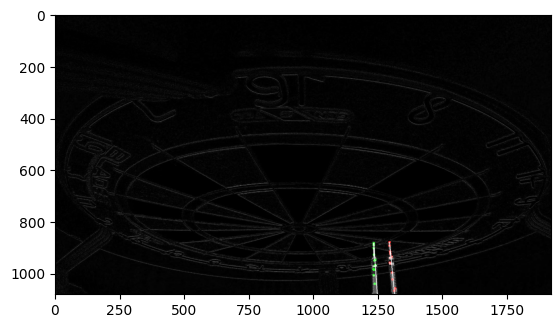

[(1292, 880), (1231, 884)]

In [36]:
#Print out the results of the functions
def main(dartFrame, emptyFrame, printOut):
    gray_dart = cv2.cvtColor(dartFrame, cv2.COLOR_BGR2GRAY)
    gray_empty = cv2.cvtColor(emptyFrame, cv2.COLOR_BGR2GRAY)
    difference = cv2.absdiff(gray_dart, gray_empty) 
    difference = cv2.cvtColor(difference, cv2.COLOR_GRAY2BGR)

    mask1 = prepareMask(dartFrame, emptyFrame)

    mask2 = np.zeros_like(mask1)
    centroids = findPointsInMask(mask1, 5)
    for (cx, cy) in centroids:
        cv2.circle(mask2, (cx, cy), 5, (255, 0, 0), -1)

    point_mask = np.zeros_like(dartFrame_og)
    line_mask = np.zeros_like(dartFrame_og)

    groups, point_mask, line_mask = groupDots(centroids, point_mask, line_mask)

    if len(centroids) > 0:
        groups.append(centroids)

    darts = findDartPositions(groups[0:3])

    colors = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (0, 255, 255)
    ]

    mask3 = np.zeros_like(dartFrame_og)
    for index, group in enumerate(groups):
        color = colors[index % len(colors)] 
        for (cx, cy) in group:
            cv2.circle(mask3, (cx, cy), 5, color, -1)

    mask3 = cv2.add(line_mask, mask3)

    result_image = cv2.add(mask3, difference)
    if(printOut):
        print(darts)
        cv2.imwrite('difference.jpg', difference)
        cv2.imwrite('mask1.jpg', mask1)
        cv2.imwrite('mask2.jpg', mask2)
        cv2.imwrite('mask3.jpg', mask3)
        cv2.imwrite('result.jpg', result_image)
        cv2.imwrite('point_mask.jpg', point_mask)
        plt.imshow(result_image)
        plt.show()

    return darts

dartFrame_og = cv2.imread('darts.jpg')
emptyFrame_og = cv2.imread('empty.jpg')

#main(dartFrame_og, emptyFrame_og, True) #Funktioniert

dartFrame_top = cv2.imread('./images/dart_top.jpg')
emptyFrame_top = cv2.imread('./images/empty_top.jpg')

main(dartFrame_top, emptyFrame_top, True) 

dartFrame_left = cv2.imread('./images/dart_left.jpg')
emptyFrame_left = cv2.imread('./images/empty_left.jpg')

#main(dartFrame_left, emptyFrame_left, True) 

dartFrame_right = cv2.imread('./images/dart_right.jpg')
emptyFrame_right = cv2.imread('./images/empty_right.jpg')

#main(dartFrame_right, emptyFrame_right, True) 

dartFrame_gemein_right = cv2.imread('./images/gemein_right.jpg')
dartFrame_gemein_left = cv2.imread('./images/gemein_left.jpg')
dartFrame_gemein_top = cv2.imread('./images/gemein_top.jpg')

#main(dartFrame_gemein_top, emptyFrame_top, True)
#main(dartFrame_gemein_right, emptyFrame_right, True)
#main(dartFrame_gemein_left, emptyFrame_left, True)

In [37]:
import unittest

class TestMainMethod(unittest.TestCase):
    def test_main_return_value(self):
        dartFrame_og = cv2.imread('darts.jpg')
        emptyFrame_og = cv2.imread('empty.jpg')

        self.assertEqual(main(dartFrame_og, emptyFrame_og, False), [(1296, 460), (615, 604), (1027, 702)])

        dartFrame_top = cv2.imread('./images/dart_top.jpg')
        emptyFrame_top = cv2.imread('./images/empty_top.jpg')

        self.assertEqual(main(dartFrame_top, emptyFrame_top, False), [(549, 507), (1233, 512), (984, 673)])

        dartFrame_left = cv2.imread('./images/dart_left.jpg')
        emptyFrame_left = cv2.imread('./images/empty_left.jpg')

        self.assertEqual(main(dartFrame_left, emptyFrame_left, False), [(1288, 757), (541, 767), (970, 904)])

        dartFrame_right = cv2.imread('./images/dart_right.jpg')
        emptyFrame_right = cv2.imread('./images/empty_right.jpg')

        self.assertEqual(main(dartFrame_right, emptyFrame_right, False), [(1295, 670), (609, 730), (1050, 838)])

        dartFrame_gemein_right = cv2.imread('./images/gemein_right.jpg')
        dartFrame_gemein_left = cv2.imread('./images/gemein_left.jpg')
        dartFrame_gemein_top = cv2.imread('./images/gemein_top.jpg')

        self.assertEqual(main(dartFrame_gemein_top, emptyFrame_top, False), [(865, 368), (967, 385), (923, 404)])
        self.assertEqual(main(dartFrame_gemein_left, emptyFrame_left, False), [(1292, 880), (1231, 884)])       
        self.assertEqual(main(dartFrame_gemein_right, emptyFrame_right, False), [(642, 808), (678, 812)])

unittest.main(argv=[''], verbosity=2, exit=False)

test_main_return_value (__main__.TestMainMethod.test_main_return_value) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.751s

OK


In [ ]:
#Zweiter Approach über Im Raum Geöffnete Parabeln (zu ineffizient, wenn es auch mit Geraden geht)

def draw_function(vertex, slope):
    #Diagonal Quadratic Formula
    # y * cos(θ) + k * cos(θ) - x * sin(θ) - h * sin(θ) = a * ((x * cos(θ) + h * cos(θ)) + (y * sing(θ) + k * sin(θ)))^2
    a = 2 #Streckungsfaktor
    θ = 1 #Winkeldrehung der Gleichung
    k = 0 #y-Achsen Verschiebung
    h = 0 #x-Achsen Verschiebung

    # k = vertex[1]  # y-Achsen Verschiebung (vertex y)
    # h = vertex[0]

    print(vertex)

    cos_theta = np.cos(θ)
    sin_theta = np.sin(θ)

    mask = np.zeros_like(dartFrame)

    width = len(dartFrame)
    height = len(dartFrame[0])

    print(width)
    print(height)

    mul = 1

    for x in range(50):
        # Berechne y aus der quadratischen Formel
        # Umstellen der Formel nach y:
        # y * cos(θ) + k * cos(θ) - x * sin(θ) - h * sin(θ) = a * ((x * cos(θ) + h * cos(θ)) + (y * sin(θ) + k * sin(θ)))^2
        # Um die Gleichung nach y umzustellen, benötigen wir:
        # y * cos(θ) = x * sin(θ) + h * sin(θ) + a * ((x * cos(θ) + h * cos(θ))^2)
        
        # Berechnung
        y_term = (x * sin_theta + h * sin_theta - k * cos_theta + 
                   a * ((x * cos_theta + h * cos_theta) ** 2))

        # Überprüfe, ob cos(θ) nicht null ist, um Division durch Null zu vermeiden
        if cos_theta != 0:
            y = y_term / cos_theta
        else:
            y = np.inf
        print(y)

        # Überprüfe, ob der y-Wert innerhalb der Maske liegt
        if 0 <= int(y) < height:
            x_trans = vertex[0] + x * mul
            y_trans = vertex[1] + int(y)
            cv2.circle(mask, (x_trans, y_trans), 5, (255, 255, 255), -1)
            mul *= -1
    
    cv2.imwrite('quadratic.jpg', mask)

    return mask